# Milestone 6 - Implementing Neural Style Transfer

__Objective__: Use Artificial Intelligence to create art using the Neural Style Transfer algorithm that was introduced by Gatys et al. in their 2015 paper titled, ‘A Neural Algorithm of Artistic Style’. We will be applying the artistic style from an image (we’ll call this the style image) to another image (our content image). We will be performing this style transfer using a 3-component loss function that includes the Content Loss, Style Loss, and the Total Variation Loss

__Notes__:
- Recall from earlier lessons that within the space of a pretrained CNN, there is stored ‘knowledge’ known as the latent space. The filters of pretrained CNNs are hierarchical learners which means the lower layers store information relating to simple local information such as blobs, colors, edges, etc. Mid-tier layers capture a combination of things from lower layers to recognize corners and simple shapes. The upper layers capture more complex patterns and abstract features. 
- It is advised you use Keras instead of the Keras included with TensorFlow 2.0.
- Use the requirements.txt file attached


__Workflow__:

1. Let’s start developing the intuition for our loss functions. We first need to develop a Content Loss function. 
    - In order to preserve the contour lines and spatial layouts of our content image, if we propagate our image through a pretrained CNN and look at the activations of the upper or higher layers, it should activate on well defined/recognizable abstract qualities in the image. 
Y    - ou will need to compute the activation of a specific upper layer, for instance, if using VGG19 (recommended), you can utilize the filter named, `block4_conv2` for both your content and style images.
    - Compute the L2-norm (sum of squared differences) between these activations. The content loss is the L2-norm between the features of our input image and the features of the generated, output image.
    - Our Content Loss function’s aim is to ensure the output generated image will have some similarity to the content image.
2. Let’s develop the intuition behind our Style loss. Instead of a single upper layer, we will utilize multiple layers of our pretrained CNN to obtain our style loss function. This is because we wish to capture multi-scale representations and textures from our style image. This allows us to capture the local style and avoid capturing global arrangements.
    - We use multiple layers for example (if using VGG19) `['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'Block5_conv1']
    - Our goal during training is to minimize the loss between the style of our generated image and the style of our style image. This ensures that the style of our generated images is correlated to the style of the style image. 
    - In order to build this style loss function, we need to compute the correlations between the activation layers of our selected CNN filters. To do this we compute the Gram Matrix between the activations of these layers. A Gram matrix is the inner product of a set of features maps.
3. Build a function that returns the Gram Matrix. The Gram Matrix in our case is the dot product between the input vectors (feature maps) and their transpose. This can be built by:
    - Flattening the input features using `features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))`
    - Then finding the dot product with its transpose. This can be done with the Keras backend function shown here: `gram = K.dot(features, K.transpose(features))`
    - Computing the L2 norm allows us to force our generated output image to have similar style characteristics, but not necessarily the same structural contents, as the style image.
4. We finally get to our third loss function, the Total-Variation loss which now operates only on the output image. This function was not part of the original paper by Gatys et al. but was introduced later on due to better spatial smoothness in the output image (i.e. more locally coherent).  It’s effectively a measure of noise in an image and thus by lowering its loss, we make more aesthetically appealing images. To obtain the Total Variation loss, you will need to:
    - Shift the image one pixel to the right and calculate the sum of squared error between the transferred and original. 
    - To square our tensors we can use the Keras backend function `k.square` and to get the sum we can use `k.sum`
    - Then we do this again by we shift the image one pixel down this time
5. Now you can combine all three loss functions to obtain one single loss function to minimize:
    - This is given as `total_loss = [style(style_image) - style(generated_image)] + [content(original_image) - content(generated_image)] + total_variation_loss`
6. Now that you have loss functions, let’s start putting together some helper utility functions to implement Neural Style Transfer
    - Create a `pre_process_image()` function that takes the image or input path to an image as its argument and outputs an image using the `vgg19.preprocess_input()` function.
    - Create a `deprocess_image()` function that removes the zero-center by mean pixel and clips the output values between 0 and 255
7. Define two Keras variables to store our content and style images to get the tensor representations of our images.
    - Use the Keras backend function `K.variable` to get the tensor representation
    - Create a placeholder for our generated output image using `K.placeholder((1, img_nrows, img_ncols, 3))`
8. Combine the three images into one single input tensor using `K.concatenate()`.
9. Load the pretrained (imagenet)  VGG19 network using our input tensor (i.e. our 3 images) as the input without loading the top of the network.
10. Select your network layer you will be using for your Content Loss.  We use upper layers so that high-level features are represented so selecting `block5_conv2` for instance would be a good choice.  Get the symbolic outputs of each key layer like this:
    - `outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])`
    - Get the single  `layer_features = outputs_dict['block5_conv2']`
11. Now we can extract the features from the layer that we chose from the input tensor like this:
    - `content_image_features = layer_features[0, :, :, :]`
    - `combined_features = layer_features[2, :, :, :]`
12. Finally, we loop through these feature_layers to calculate the style loss.
13. We now need to create a way to get the gradients of the generated image with respect to the loss.
    - You can use Keras’s `K.gradients` and `k.function` to build this.
    - After which create a simple function called `eval_loss_and_grads` that will  return the loss and gradients

14. Create a class called `evaluator` that contains methods that calculate the overall loss and gradients as described previously. This is needed so that we can compute our  loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because scipy.optimize  requires separate functions for loss and gradients, but computing them separately would be inefficient.

15. All our building blocks are now in place to implement the Neural Style Transfer Algorithm. However, we can fine-tune the weightings of the contribution of the style and content images by using some weighting parameters. These are multiplied by each type of loss. They are the `content_weight`, `total_variation_weight` and the `style_weight`.

16. Start iteratively minimize our total loss function. The original article recommends using the scipy-based optimization method called `scipy.optimize.fmin_l_bfgs_b`, but it is easier to just use Adam.
    - To be track on this training process for each iteration print out some logging information such as the Iteration no. and  the loss 
    - Display your Neural Style Transfer generated image the end
17. Experiment with different weighting combinations, different layers, number of iterations and of course changing your content and style images to create amazing AI-generated art using NST!


In [1]:
# Import our modules.
from __future__ import print_function
from tensorflow.keras.utils import load_img, save_img, img_to_array
import numpy as np
import tensorflow as tf
import time
import IPython.display as display
import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False


# Import our VGG19 model
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K

2023-03-13 17:15:36.425936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download our style and base images

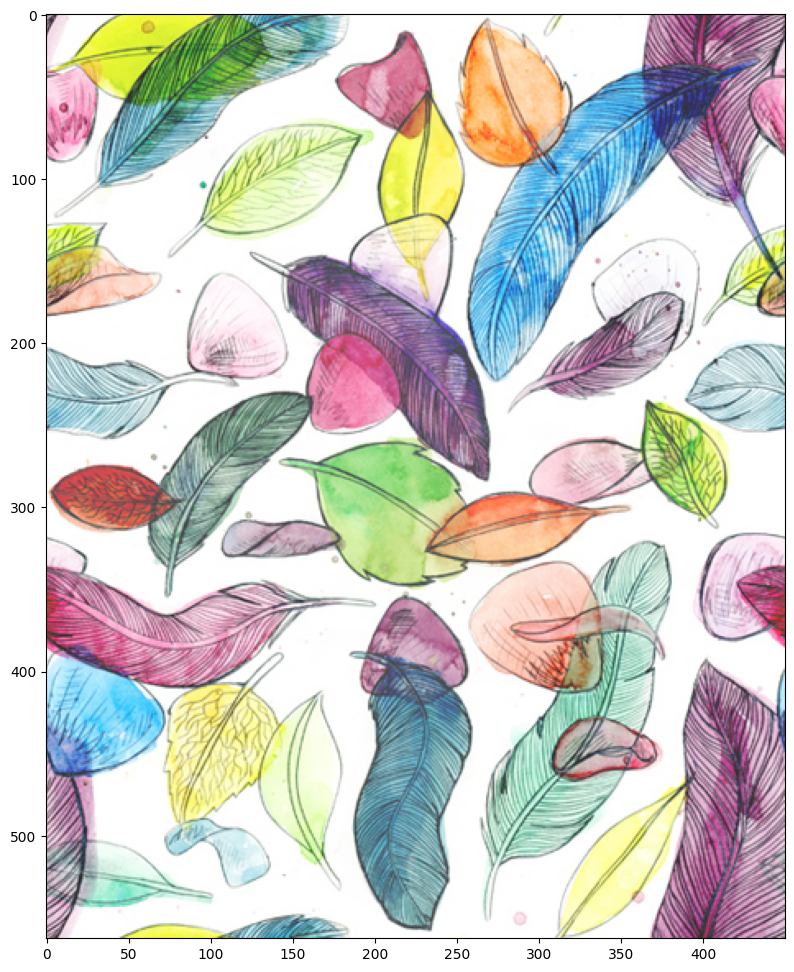

In [ ]:
import wget
import os

url_s = "https://i.imgur.com/GwoGyMl.jpg" #Download Feathers Style Image
# url_s = "https://i.imgur.com/UkgSWFV.jpg" #Download Candy Style Image
# url_S = "https://i.imgur.com/ivOAEV1.jpg" #Download Mosaic Style Image

#style_image = wget.download(url_s)
#os.rename(style_image, "style_image.jpg")

url_b = "https://i.imgur.com/UCDA6NR.jpg" #Download Base Image"

#base_image = wget.download(url_b)
#os.rename(base_image, "base_image.jpg")

style = PIL.Image.open('style_image.jpg')
plt.imshow(style)
plt.show()

In [4]:
# Point to our image paths for our content/base image and style images
base_image_path = 'base_image.jpg'
style_reference_image_path = 'style_image.jpg'
result_prefix = "output_"

### These are the weights of the different loss components

#### Set the dimensions of the generated image

In [5]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [10]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#### Convert out images to tensor representations

In [12]:
# get tensor representations of our images
base_image = load_img(base_image_path)
style_reference_image = load_img(style_reference_image_path)

#### Examine what a tensor looks like

In [13]:
# Examine our tensor shape
base_image.shape

TensorShape([1, 512, 384, 3])

### Load our pretrained VGG19 without the head and the top layer and extract the layers we need to create the new image

In [14]:
def vgg_layers(layer_names):
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    print('Model loaded.')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # We can extract the model names using the .name method to access it
    #print(model.layers[2].name)
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
# These are the layers used fro content and style respectively:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_reference_image*255)

Model loaded.


## The Gram Matrix function

In [17]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
  result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
  input_shape = tf.shape(x)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


## We define now our model that returns our style and content tensors

In [18]:
class StyleContentModel(tf.keras.models.Model):
    
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


Once this model is called on an image, it returns the Gram Matrix of the `style_layers`, and the content of the `content_layers`

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_reference_image)['style']
content_targets = extractor(base_image)['content']


Model loaded.


We are now ready to run gradient descent! Let's define first a variable which will contain the image to optimize:

In [20]:
image = tf.Variable(base_image)

# define a clip function, to avoid having pixel values outside the [0...1] range
def clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 0.01
content_weight = 10000

We now combine our style and content loss into a single `style_content_loss`, to which we will later add the `variation_loss`

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

And we now finally define our training step, using `GradientTape`

In [24]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image) # to avoid high frequency artifacts

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip(image))


And run the optimization:

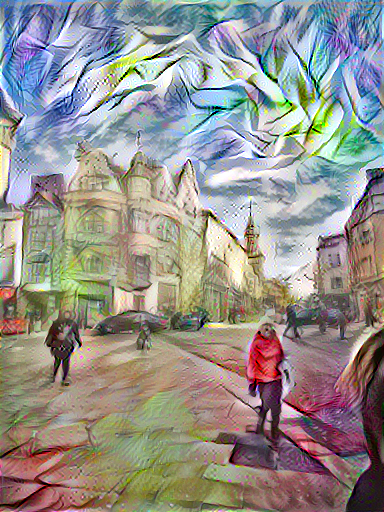

Train step: 300
Total time: 1118.3


In [26]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


import time
start = time.time()

epochs = 3
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


__Summary__:

In this notebook we:
- Loaded a pretrained (imagenet) VGG19 model without its top layer and used it to implement the Neural Style Transfer Algorithm.
- We created 3 loss function, content loss, style loss, and total variance loss and combined them into a single loss function that was minimized in order to produce a generated image that copied the style of our style image onto our content image. 

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow as you create your loss functions and then combine them using the recommended Keras functions. You are then to load your own content and style images and implement the Neural Style Transfer algorithm to create your own Art. Create a few different variations of your Art using different layers and weighting parameters. 
